<table border="0">
    <tr>
        <td>
            <img src="https://ictd2016.files.wordpress.com/2016/04/microsoft-research-logo-copy.jpg" style="width 30px;" />
             </td>
        <td>
            <img src="https://www.microsoft.com/en-us/research/wp-content/uploads/2016/12/MSR-ALICE-HeaderGraphic-1920x720_1-800x550.jpg" style="width 100px;"/></td>
        </tr>
</table>

# Double Machine Learning: Summarized Data and Interpretability

Double Machine Learning (DML) is an algorithm that applies arbitrary machine learning methods
to fit the treatment and response, then uses a linear model to predict the response residuals
from the treatment residuals.

To run this jupyter notebook, you need to clone and setup the EconML library version from the branch:
https://github.com/microsoft/EconML/tree/vasilis/cate_interpreters

`git clone git@github.com:microsoft/EconML.git`

`git checkout vasilis/cate_interpreters`

`python setup.py develop`

For more information on these classes you can locally build the documentation for this branch using the instructions from the README: i.e. 

`python setup.py build_sphinx -W -E -a`


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
## Ignore warnings
import warnings
warnings.filterwarnings('ignore') 

In [3]:
# Helper imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import seaborn as sns

# Generating Raw Data

In [4]:
import scipy.special

np.random.seed(123)
n=10000 # number of raw samples
d=10 # number of binary features + 1

# Generating random segments aka binary features. We will use features 1,...,4 for heterogeneity.
# The rest for controls. Just as an example.
X = np.random.binomial(1, .5, size=(n, d))
# The first column of X is the treatment. Generating an imbalanced A/B test
X[:, 0] = np.random.binomial(1, scipy.special.expit(X[:, 1]))
# Generating an outcome with treatment effect heterogeneity. The first binary feature creates heterogeneity
# We also have confounding on the first variable. We also have heteroskedastic errors.
y = (-1 + 2 * X[:, 1]) * X[:, 0] + X[:, 1] + (1*X[:, 1] + 1)*np.random.normal(0, 1, size=(n,))

# Creating Summarized Data

For each segment, we split the data in two and create one summarized copy for each split. The summarized copy contains the number of samples that were summarized and the variance of the observations for the summarized copies. Optimally we would want two copies per segment, as I'm creating here, but with many segments, the approach would work ok even with a single copy per segment.

In [5]:
from econml.tests.test_statsmodels import _summarize

X_sum = np.unique(X, axis=0)
n_sum = np.zeros(X_sum.shape[0])
# The _summarize function performs the summary operation and returns the summarized data
# For each segment we have two copies.
X1, X2, y1, y2, X1_sum, X2_sum, y1_sum, y2_sum, n1_sum, n2_sum, var1_sum, var2_sum = _summarize(X, y)

# We concatenate the two copies data
X_sum = np.vstack([X1_sum, X2_sum]) # first coordinate is treatment, the rest are features
y_sum = np.concatenate((y1_sum, y2_sum)) # outcome
n_sum = np.concatenate((n1_sum, n2_sum)) # number of summarized points
var_sum = np.concatenate((var1_sum, var2_sum)) # variance of the summarized points
splits = (np.arange(len(y1_sum)), np.arange(len(y1_sum), len(y_sum))) # indices of the two summarized copies

# Applying the LinearDMLCateEstimator

In [6]:
from econml.sklearn_extensions.linear_model import WeightedLassoCV
from econml.dml import LinearDMLCateEstimator
from sklearn.linear_model import LogisticRegressionCV

# One can replace model_y and model_t with any scikit-learn regressor and classifier correspondingly
# as long as it accepts the sample_weight keyword argument at fit time.
est = LinearDMLCateEstimator(model_y=WeightedLassoCV(cv=3),
                             model_t=LogisticRegressionCV(cv=3),
                             discrete_treatment=True)
est.fit(y_sum, X_sum[:, 0], X=X_sum[:, 1:5], W=X_sum[:, 5:],
        sample_weight=n_sum, sample_var=var_sum, inference='statsmodels')

In [7]:
# Treatment Effect of particular segments
est.effect(np.array([[1, 0, 0, 0]])) # effect of segment with features [1, 0, 0, 0]

array([1.05058881])

In [8]:
# Confidence interval for effect
est.effect_interval(np.array([[1, 0, 0, 0]]), alpha=.05) # effect of segment with features [1, 0, 0, 0]

(array([0.88802699]), array([1.21315063]))

In [9]:
# Getting the coefficients of the linear CATE model together with the corresponding feature names
print(np.array(list(zip(est.cate_feature_names(['A', 'B', 'C', 'D']), est.coef_))))

[['A' '1.9341643859534092']
 ['B' '0.03619394835020995']
 ['C' '-0.0429551282153916']
 ['D' '-0.15131326118352362']]


## Non-Linear CATE Models with Polynomial Features

In [10]:
from econml.sklearn_extensions.linear_model import WeightedLassoCV
from econml.dml import LinearDMLCateEstimator
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import PolynomialFeatures

# One can replace model_y and model_t with any scikit-learn regressor and classifier correspondingly
# as long as it accepts the sample_weight keyword argument at fit time.
est = LinearDMLCateEstimator(model_y=WeightedLassoCV(cv=3),
                             model_t=LogisticRegressionCV(cv=3),
                             featurizer=PolynomialFeatures(degree=2, interaction_only=True, include_bias=False),
                             discrete_treatment=True)
est.fit(y_sum, X_sum[:, 0], X=X_sum[:, 1:5], W=X_sum[:, 5:],
        sample_weight=n_sum, sample_var=var_sum, inference='statsmodels')

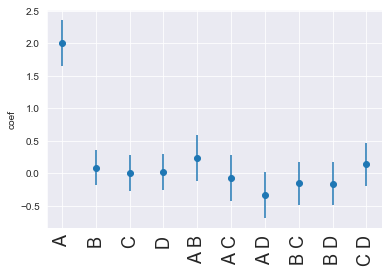

In [11]:
# Getting the confidence intervals of the coefficients of the CATE model
# together with the corresponding feature names.
feat_names = est.cate_feature_names(['A', 'B', 'C', 'D'])
point = est.coef_
lower, upper = est.coef__interval(alpha=.01)
yerr = np.zeros((2, point.shape[0]))
yerr[0, :] = point - lower
yerr[1, :] = upper - point

with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(1,1)
    x = np.arange(len(point))
    plt.errorbar(x, point, yerr, fmt='o')
    ax.set_xticks(x)
    ax.set_xticklabels(feat_names, rotation='vertical', fontsize=18)
    ax.set_ylabel('coef')
    plt.show()

# Tree Interpretation of the CATE Model

In [12]:
from econml.cate_interpreter import SingleTreeCateInterpreter

In [13]:
intrp = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=2, min_samples_leaf=1)
# We interpret the CATE models behavior on the distribution of heterogeneity features
intrp.interpret(est, X_sum[:, 1:5])

In [14]:
# exporting to a dot file
intrp.export_graphviz(out_file='cate_tree.dot', feature_names=['A', 'B', 'C', 'D'])

In [15]:
# or we can directly render. Requires the graphviz python library
intrp.render(out_file='cate_tree', format='pdf', view=True, feature_names=['A', 'B', 'C', 'D'])

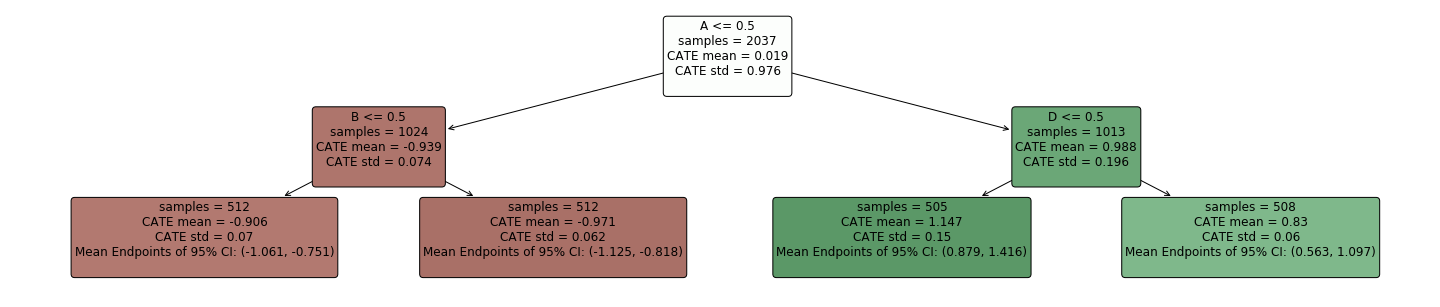

In [16]:
# or we can also plot inline with matplotlib. a bit uglier
plt.figure(figsize=(25, 5))
intrp.plot(feature_names=['A', 'B', 'C', 'D'], fontsize=12)
plt.show()

# Tree Based Treatment Policy Based on CATE Model

In [17]:
from econml.cate_interpreter import SingleTreePolicyInterpreter

In [18]:
intrp = SingleTreePolicyInterpreter(risk_level=0.05, max_depth=3, min_samples_leaf=1, min_impurity_decrease=.001)
# We find a tree based treatment policy based on the CATE model
# sample_treatment_costs is the cost of treatment. Policy will treat if effect is above this cost.
# It can also be an array that has a different cost for each sample. In case treating different segments
# has different cost.
intrp.interpret(est, X_sum[:, 1:5],
                sample_treatment_costs=0)

In [19]:
# exporting to a dot file
intrp.export_graphviz(out_file='cate_tree.dot', feature_names=['A', 'B', 'C', 'D'])

In [20]:
# or we can directly render. Requires the graphviz python library
intrp.render(out_file='policy_tree', format='pdf', view=True, feature_names=['A', 'B', 'C', 'D'])

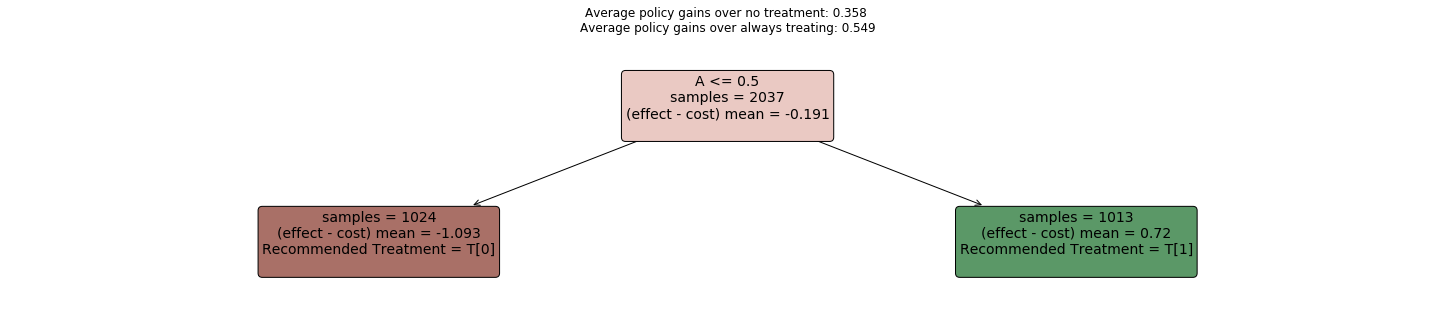

In [21]:
# or we can also plot inline with matplotlib. a bit uglier
plt.figure(figsize=(25, 5))
intrp.plot(feature_names=['A', 'B', 'C', 'D'], fontsize=14)
plt.show()

# Appendix: Amendment

To make estimation even more precise one should simply choose the two splits used during the crossfit part of Double Machine Learning so that each summaried copy of a segment ends up in a separate split. We can do this as follows: 

In [22]:
from econml.sklearn_extensions.linear_model import WeightedLassoCV
from econml.dml import LinearDMLCateEstimator
from sklearn.linear_model import LogisticRegressionCV

# One can replace model_y and model_t with any scikit-learn regressor and classifier correspondingly
# as long as it accepts the sample_weight keyword argument at fit time.
est = LinearDMLCateEstimator(model_y=WeightedLassoCV(cv=3),
                             model_t=LogisticRegressionCV(cv=3),
                             discrete_treatment=True,
                             n_splits=[(splits[0], splits[1]), (splits[1], splits[0])]) # we input custom fold structure
est.fit(y_sum, X_sum[:, 0], X=X_sum[:, 1:5], W=X_sum[:, 5:],
        sample_weight=n_sum, sample_var=var_sum, inference='statsmodels')

In [23]:
# Treatment Effect of particular segments
est.effect(np.array([[1, 0, 0, 0]])) # effect of segment with features [1, 0, 0, 0]

array([1.0554521])

In [24]:
# Confidence interval for effect
est.effect_interval(np.array([[1, 0, 0, 0]])) # effect of segment with features [1, 0, 0, 0]

(array([0.91936532]), array([1.19153889]))